In [1]:
import pandas as pd
import numpy as np
import sklearn as skl
from sklearn import preprocessing as pp
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import sys 
import datetime
import math
from datetime import date

##### Loading Data

In [2]:
Data = pd.read_excel("..\data\Online Retail.xlsx")

In [3]:
online = Data

## Exploratory data analysis

### Unique Value Analysis

In [4]:

counts = [{"InvoiceNo" : online['InvoiceNo'].nunique(), \
           "StockCode" : online['StockCode'].nunique(), \
           "Description" : online['Description'].nunique(),\
           "Quantity" : online['Quantity'].nunique(), \
           "InvoiceDate" : online['InvoiceDate'].nunique(), \
           "CustomerID" : online['CustomerID'].nunique(), \
           "Country" : online['Country'].nunique()}]
counts

[{'InvoiceNo': 25900,
  'StockCode': 4070,
  'Description': 4223,
  'Quantity': 722,
  'InvoiceDate': 23260,
  'CustomerID': 4372,
  'Country': 38}]

### Missing Data Analysis

In [5]:
online.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
online.shape

(541909, 8)

Remove any missing from CustomerID as we are trying to segment customers.

In [7]:
online = online[pd.notnull(online['CustomerID'])]
online.isna().sum()
online.shape

(406829, 8)

### Column Removal
We can try to determine the importance of the Description column. As seen below, description is more or less a duplicate of stock code. There are more unique values in description because certain descriptions may slightly vary at different times. We can assume that each description corresponds with a unique stock code, therefore we can drop it.

In [8]:
is_code = online['StockCode'] == 71053
description_for_code = online[is_code]['Description']
description_for_code.drop_duplicates()

# is_code = online['StockCode'] == '84406B'
# description_for_code = online[is_code]['Description']
# description_for_code.drop_duplicates()

1                  WHITE METAL LANTERN
491875    WHITE MOROCCAN METAL LANTERN
Name: Description, dtype: object

In [9]:
online = online.drop('Description',axis=1)
online.dtypes

InvoiceNo              object
StockCode              object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

### Negative Quantity Values 

Identify any negative quantity values. These can be useful monetary analysis however should be removed for frequency and recency. There are records that are not purchases, some are for negative quantities, indicating they are returns/canceled orders. These records should not be included in the analysis, but we have to make a decision as to what to do with the orders that are being cancelled. In some cases there is only one pair of StockCode, CustomerID (eg one purchase which was later returned), which would suggest that the return and original purchase should both be removed. In other cases, a customer may have purchased the item multiple times and/or in a higher quantity that is being retured (eg purchases 6 units, returns 2 or puchases 1 unit 6 times, then returns 2). In this case, subtracting the monetary value of the return from the customers total expendature is necessary. So we wil get the net purchase value per customer, remove the transactions with negative quantities, then construct the frequency and recency measures from the original purchases

In [10]:
online.Quantity.min()

-80995

In [11]:
online[online['Quantity'] < 0 ].head(n=5)

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


## Data Preparation
Need to make statistics for each customer ID:
- Recency (date since last transaction)
- Frequency (how often purchases are made)
- Monetary (value of spending per customer) 

We do monetary analysis first as we need to keep the negative quantity. 

In [12]:
#Monetary Analysis
#Getting the value of each transaction (invoice number)
temp = online
temp['ItemValue'] = online['Quantity'] * online['UnitPrice']
temp = pd.DataFrame(online,columns=['CustomerID','ItemValue'])
Customer_Monetary = temp.groupby('CustomerID').sum().reset_index()
Customer_Monetary.rename(columns = {"ItemValue":"MonetaryValue"}, inplace = True)


test = online[online['CustomerID'] == 12346.0]['ItemValue']
print(test)
print(Customer_Monetary.head(n=10))
Customer_Monetary.shape #4372 rows, which matches the total number of Customers

61619    77183.6
61624   -77183.6
Name: ItemValue, dtype: float64
   CustomerID  MonetaryValue
0     12346.0           0.00
1     12347.0        4310.00
2     12348.0        1797.24
3     12349.0        1757.55
4     12350.0         334.40
5     12352.0        1545.41
6     12353.0          89.00
7     12354.0        1079.40
8     12355.0         459.40
9     12356.0        2811.43


(4372, 2)

In [13]:
online_eng = online
online_eng = online_eng[online_eng['Quantity'] > 0 ]
online_eng.Quantity.min()

1

In [14]:
# Recency Analysis
# getting the recency of each transaction, will take the min per customer
last = date(2011,12, 9)
last = pd.to_datetime(last)
temp = pd.DataFrame(online_eng,columns=['CustomerID','InvoiceDate'])
LastTransaction = temp.groupby('CustomerID').InvoiceDate.max().reset_index()
LastTransaction['Recency'] = (last - LastTransaction['InvoiceDate']).dt.days
Customer_Recency = pd.DataFrame(LastTransaction,columns=['CustomerID','Recency'])
# online['Recency'] = Customer_Recency['Recency']
print(Customer_Recency)

      CustomerID  Recency
0        12346.0      324
1        12347.0        1
2        12348.0       74
3        12349.0       17
4        12350.0      309
...          ...      ...
4334     18280.0      276
4335     18281.0      179
4336     18282.0        6
4337     18283.0        2
4338     18287.0       41

[4339 rows x 2 columns]


In [15]:
# Frequency analysis
temp = pd.DataFrame(online_eng,columns=['CustomerID','InvoiceDate'])
Customer_Frequency = temp.groupby('CustomerID').InvoiceDate.count().reset_index()
Customer_Frequency.rename(columns = {"InvoiceDate":"Frequency"}, inplace = True)
print(Customer_Frequency)

      CustomerID  Frequency
0        12346.0          1
1        12347.0        182
2        12348.0         31
3        12349.0         73
4        12350.0         17
...          ...        ...
4334     18280.0         10
4335     18281.0          7
4336     18282.0         12
4337     18283.0        756
4338     18287.0         70

[4339 rows x 2 columns]


In [16]:
RFM_data = Customer_Recency.merge(Customer_Frequency, on='CustomerID', how='left')
RFM_data = RFM_data.merge(Customer_Monetary, on='CustomerID', how='left')
print(RFM_data.shape)
print(RFM_data.head(n=10))

(4339, 4)
   CustomerID  Recency  Frequency  MonetaryValue
0     12346.0      324          1           0.00
1     12347.0        1        182        4310.00
2     12348.0       74         31        1797.24
3     12349.0       17         73        1757.55
4     12350.0      309         17         334.40
5     12352.0       35         85        1545.41
6     12353.0      203          4          89.00
7     12354.0      231         58        1079.40
8     12355.0      213         13         459.40
9     12356.0       21         59        2811.43


In [17]:
#Normalization makes training less sensitive to the scale of features, so we can better solve for coefficients.
# features_to_normalize = ['Recency', 'Frequency', 'MonetaryValue']
RFM = RFM_data.copy()
# RFM_type2 = RFM_data.copy()
# RFM_data_normalized = RFM_data.copy()
# RFM_data_normalized[features_to_normalize] = RFM_data_normalized[features_to_normalize].apply(lambda x:(x-x.min()) / (x.max()-x.min()))

In [18]:
print(RFM.head(n=10))


   CustomerID  Recency  Frequency  MonetaryValue
0     12346.0      324          1           0.00
1     12347.0        1        182        4310.00
2     12348.0       74         31        1797.24
3     12349.0       17         73        1757.55
4     12350.0      309         17         334.40
5     12352.0       35         85        1545.41
6     12353.0      203          4          89.00
7     12354.0      231         58        1079.40
8     12355.0      213         13         459.40
9     12356.0       21         59        2811.43


In [19]:
# print(RFM.head(n=10))

## Clustering
K-Means clustering is used.
A two step process is used:
1. Ranking R, F, and M to a scale of 5.
2. Clustering on R, F, and M at the same time


### Ranking

In [20]:
#Create 5 segments
segments = RFM.quantile(q=[0.20,0.4,0.6,0.8])
segments = segments.to_dict()

In [21]:
#Create a copy of the table to rank on.
RFM_ranked = RFM.copy()

In [22]:
def Recency_Score(val,index,df):
    if val <= df[index][0.2]:
        return 5
    elif val <= df[index][0.4]:
        return 4
    elif val <= df[index][0.6]: 
        return 3
    elif val <= df[index][0.8]: 
        return 2
    else:
        return 1
    
def Frequency_Score(val,index,df):
    if val <= df[index][0.2]:
        return 1
    elif val <= df[index][0.4]:
        return 2
    elif val <= df[index][0.6]: 
        return 3
    elif val <= df[index][0.8]: 
        return 4
    else:
        return 5
    
def Monetary_Score(val,index,df):
    if val <= df[index][0.2]:
        return 1
    elif val <= df[index][0.4]:
        return 2
    elif val <= df[index][0.6]: 
        return 3
    elif val <= df[index][0.8]: 
        return 4
    else:
        return 5

In [23]:
RFM_ranked['R_rank'] = RFM_ranked['Recency'].apply(Recency_Score, args=('Recency',segments,))
RFM_ranked['F_rank'] = RFM_ranked['Frequency'].apply(Frequency_Score, args=('Frequency',segments,))
RFM_ranked['M_rank'] = RFM_ranked['MonetaryValue'].apply(Monetary_Score, args=('MonetaryValue',segments,))
RFM_ranked.head()

,CustomerID,Recency,Frequency,MonetaryValue,R_rank,F_rank,M_rank
0,12346.0,324,1,0.00,1,1,1
1,12347.0,1,182,4310.00,5,5,5
2,12348.0,74,31,1797.24,2,3,4
3,12349.0,17,73,1757.55,4,4,4
4,12350.0,309,17,334.40,1,2,2


In [24]:
# Create a combined ranking by summing R F and M.
RFM_ranked['Combined_rank'] = RFM_ranked.R_rank + RFM_ranked.F_rank + RFM_ranked.M_rank
RFM_ranked.head()

,CustomerID,Recency,Frequency,MonetaryValue,R_rank,F_rank,M_rank,Combined_rank
0,12346.0,324,1,0.00,1,1,1,3
1,12347.0,1,182,4310.00,5,5,5,15
2,12348.0,74,31,1797.24,2,3,4,9
3,12349.0,17,73,1757.55,4,4,4,12
4,12350.0,309,17,334.40,1,2,2,5


In [25]:
#Discretize combined rank into 3 groups
bins = ['Worst','Medium','Best']
RFM_ranked['Combined_rank_Labeled'] = pd.qcut(RFM_ranked['Combined_rank'], q= 3,labels =  bins)
RFM_ranked.head()

,CustomerID,Recency,Frequency,MonetaryValue,R_rank,F_rank,M_rank,Combined_rank,Combined_rank_Labeled
0,12346.0,324,1,0.00,1,1,1,3,Worst
1,12347.0,1,182,4310.00,5,5,5,15,Best
2,12348.0,74,31,1797.24,2,3,4,9,Medium
3,12349.0,17,73,1757.55,4,4,4,12,Best
4,12350.0,309,17,334.40,1,2,2,5,Worst


### K-Means Clustering

In [26]:
#Normalize data
features_to_normalize = ['Recency', 'Frequency', 'MonetaryValue']
RFM_data_normalized = RFM_ranked.copy()
RFM_data_normalized[features_to_normalize] = RFM_data_normalized[features_to_normalize].apply(lambda x:(x-x.min()) / (x.max()-x.min()))

In [27]:
RFM_data_normalized.head()

,CustomerID,Recency,Frequency,MonetaryValue,R_rank,F_rank,M_rank,Combined_rank,Combined_rank_Labeled
0,12346.0,0.871314,0.000000,0.004152,1,1,1,3,Worst
1,12347.0,0.005362,0.023069,0.019509,5,5,5,15,Best
2,12348.0,0.201072,0.003824,0.010556,2,3,4,9,Medium
3,12349.0,0.048257,0.009177,0.010414,4,4,4,12,Best
4,12350.0,0.831099,0.002039,0.005344,1,2,2,5,Worst


### Determining Number of Clusters
We Can do this using the elbow method.

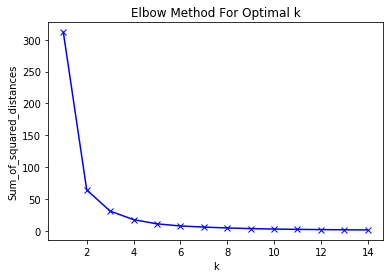

In [28]:
#Clustering using all 1 variable at once

#This serves to test the processed data set. Whether or not there is good intra-cluster and inter-cluster distances

#Determine number of clusters
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k, max_iter=1000).fit(RFM_data_normalized[['Recency']])
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [29]:
from sklearn.cluster import KMeans

#Add cluster to un-normalized data to increase interpretability 
RFM_clustered = RFM_ranked.copy()

#Clustering using all 3 variables at the same time.
km = KMeans(n_clusters = 3,max_iter=2000, n_init=1, verbose=0, random_state=3425)
predicted_cluster = km.fit_predict(RFM_data_normalized[['Recency','Frequency','MonetaryValue','Combined_rank']])
RFM_clustered['Cluster'] = predicted_cluster
total_customers = RFM_clustered["CustomerID"].nunique()

In [30]:
RFM_clustered.head(n=10)


,CustomerID,Recency,Frequency,MonetaryValue,R_rank,F_rank,M_rank,Combined_rank,Combined_rank_Labeled,Cluster
0,12346.0,324,1,0.00,1,1,1,3,Worst,0
1,12347.0,1,182,4310.00,5,5,5,15,Best,1
2,12348.0,74,31,1797.24,2,3,4,9,Medium,2
3,12349.0,17,73,1757.55,4,4,4,12,Best,1
4,12350.0,309,17,334.40,1,2,2,5,Worst,0
5,12352.0,35,85,1545.41,3,4,4,11,Medium,1
6,12353.0,203,4,89.00,1,1,1,3,Worst,0
7,12354.0,231,58,1079.40,1,3,4,8,Medium,2
8,12355.0,213,13,459.40,1,1,2,4,Worst,0
9,12356.0,21,59,2811.43,4,4,5,13,Best,1


Split the data by clusters and do analysis per cluster

In [31]:
cluster0 = RFM_clustered[RFM_clustered['Cluster'] == 0]
cluster1 = RFM_clustered[RFM_clustered['Cluster'] == 1]
cluster2 = RFM_clustered[RFM_clustered['Cluster'] == 2]

#### Results

- Show the distribution of the customers within each cluster (Ratio & Percentage of customers per cluster divided by the total number of customers)
It's clear that cluster 0 is "Worst" cluster 2 is "Medium" and cluster 3 is "Best". 

In [32]:
label = RFM_clustered.groupby(['Cluster', 'Combined_rank_Labeled'])['CustomerID'].nunique().to_frame()
label

CustomerID
Cluster Combined_rank_Labeled            
0       Worst                        1287
1       Medium                        335
        Best                         1258
2       Worst                         374
        Medium                       1085

- Show the statistics of each cluster (Min, Max, Median of clustering RFM attributes)

In [33]:
description = RFM_clustered.groupby('Cluster')[['Recency','Frequency','MonetaryValue']].describe()
description

Recency                                                           \
          count        mean         std   min   25%    50%    75%    max   
Cluster                                                                    
0        1287.0  187.834499  104.759644  13.0  87.0  191.0  272.0  372.0   
1        1593.0   23.613308   31.710113  -1.0   4.0   15.0   30.0  371.0   
2        1459.0   79.280329   74.858661  -1.0  25.0   57.0  106.0  372.0   

        Frequency              ...                MonetaryValue               \
            count        mean  ...    75%     max         count         mean   
Cluster                        ...                                             
0          1287.0   14.241647  ...   20.0    77.0        1287.0   253.974002   
1          1593.0  198.973007  ...  216.0  7847.0        1593.0  4311.706592   
2          1459.0   42.927347  ...   55.0   238.0        1459.0   764.265875   

                                                                            
                  std           min      25%      50%       75%        max  
Cluster                                                                     
0          195.726167 -1.165300e+03   134.75   215.08   332.745    2002.40  
1        13244.362738  2.497200e+02  1214.72  2089.85  3645.430  279489.02  
2          895.870255  2.664535e-14   372.70   600.39   891.795   21535.90  

[3 rows x 24 columns]

- Describe the distinct features of each cluster. For example, a cluster identifies the least or most profitable customer group, the loyal (most frequent) group, old customers with no recent purchases (low recency, high frequency and medium monetary), or potential highly profitable customers (recent and medium monetary).

In [34]:
stats = RFM_clustered.groupby(['Cluster','R_rank', 'F_rank', 'M_rank'])['CustomerID'].nunique().to_frame()
stats['Share'] = stats['CustomerID'] / total_customers*100
stats.reset_index(inplace=True)
stats.to_csv("../stats.csv")

We can see that cluster 0, which is for the worst customers, contains zero occurances of score 5 attributes. The cluster representing the medium customers has a mixed distribution of all scores, but very few which score 5 an no occureances of 5 in more than one catergory. The best cluster has mainly scores of 4 and 5. 

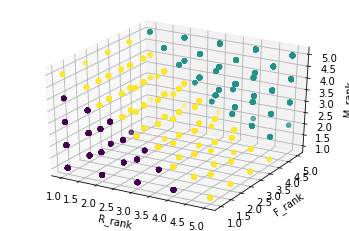

In [35]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


xs = list(RFM_clustered['R_rank'])
ys = list(RFM_clustered['F_rank'])
zs = list(RFM_clustered['M_rank'])
c = list(RFM_clustered['Cluster'])



ax.scatter(xs, ys, zs, c = c)
         
ax.set_xlabel('R_rank')
ax.set_ylabel('F_rank')
ax.set_zlabel('M_rank')

plt.show()
ax.get_figure().savefig('../3d.png')

The plot shows very clear lines of division for each cluster, there are no ambiguous data points. 

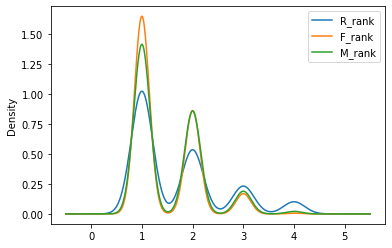

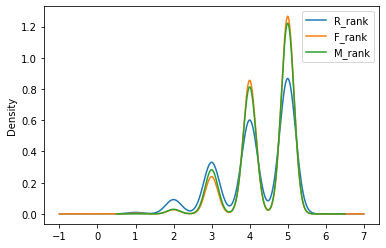

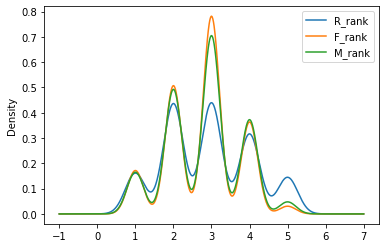

In [36]:
RFM_clustered.loc[RFM_clustered['Cluster'] == 0 , ("R_rank","F_rank","M_rank")].plot.kde().get_figure().savefig("../cluster0kd.png")
RFM_clustered.loc[RFM_clustered['Cluster'] == 1 , ("R_rank","F_rank","M_rank")].plot.kde().get_figure().savefig("../cluster1kd.png")
RFM_clustered.loc[RFM_clustered['Cluster'] == 2 , ("R_rank","F_rank","M_rank")].plot.kde().get_figure().savefig("../cluster2kd.png")
